<a href="https://colab.research.google.com/github/refercon/ipynb/blob/main/traffic_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install torch-geometric-temporal



Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached torch_geometric_temporal-0.54.0-py3-none-any.whl
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/ed/1b/72a1821152d07cf1d8b6fce298aeb06a7eb90f4d6d41acec9861e7cc6df0/decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


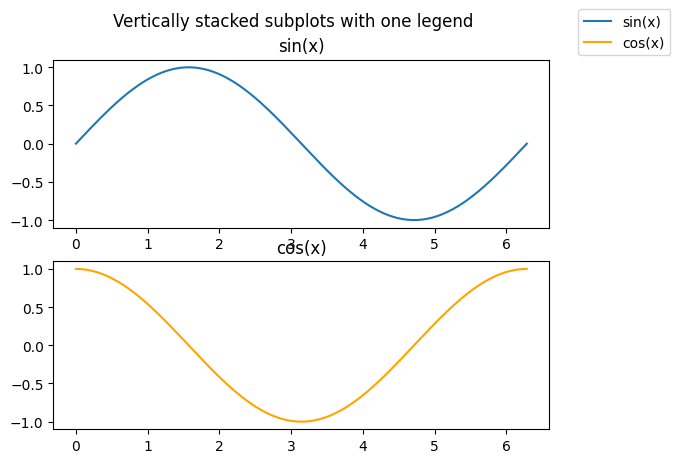

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 创建一些示例数据
x = np.linspace(0, 2 * np.pi, 400)
y1 = np.sin(x)
y2 = np.cos(x)

fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots with one legend')

# 绘制第一个子图
axs[0].plot(x, y1, label='sin(x)')
axs[0].set_title('sin(x)')

# 绘制第二个子图
axs[1].plot(x, y2, label='cos(x)', color='orange')
axs[1].set_title('cos(x)')

# 创建一个图例并放置在图形的外部
fig.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

plt.show()


## 交通流量预测
- 核心工具包：Pytorch Geometric Temporal


#### 需要额外安装的工具包-：
- pip install torch-geometric-temporal

### 数据集：选自论文Diffusion Convolutional Recurrent Neural Network

- 一共有207个传感器收集的数据(主要就是速度信息)
- 这些传感器在洛杉矶每5分钟收集一次数据

### 时间序列两种常见预测方法：

![image.png](attachment:image.png)

In [ ]:
import ssl
import urllib.request

# 禁用证书验证（全局设置）
ssl._create_default_https_context = ssl._create_unverified_context
from torch_geometric_temporal.dataset import METRLADatasetLoader

loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)#输入12个样本点 预测未来12个点的值
print("Dataset type:  ", dataset)
# 初始化计数器
num_samples = 0

# 遍历数据集以计数
for _ in dataset:
    num_samples += 1

print("Number of samples / sequences: ", num_samples)


d:\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x000001FDD81285B0>
Number of samples / sequences:  34249


#### Data Sample
- 207 个传感器
- 每个具有两个特征 (speed, time)
- 输入是12个时间点 (12 x 5 min = 60 min)
- 标签是未来12个点的速度值
- Edge_attr is build based on the distances between sensors + threshold
- 数据相关介绍: https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/dataset/metr_la.html#METRLADatasetLoader
- 原始数据下载: https://graphmining.ai/temporal_datasets/METR-LA.zip

In [ ]:
# 数据样例
next(iter(dataset))

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])

要预测的数据啥样子

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualize traffic over time
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
sns.lineplot(data=sensor_labels)
plt.show()

#### 数据集切分

In [ ]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

# print("Number of train buckets: ", len(set(train_dataset)))
# print("Number of test buckets: ", len(set(test_dataset)))

## 网络模型

A3TGCN是TGCN的拓展，加入了注意力机制，用的比较多

![image.png](attachment:image.png)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features,
                           out_channels=32,
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)#预测未来的12个值

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=2, periods=12)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

### 训练与测试

In [ ]:
# GPU support
device = torch.device('cuda') # cuda
subset = 2000

# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

print("Running training...")
for epoch in range(10):
    loss = 0
    step = 0
    for snapshot in train_dataset:
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2)
        step += 1
        if step > subset:
            break

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

Running training...


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 10.16 GiB already allocated; 0 bytes free; 10.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
model.eval()
loss = 0
step = 0
horizon = 288

# Store for analysis
predictions = []
labels = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    # Store for analysis below
    labels.append(snapshot.y)
    predictions.append(y_hat)
    step += 1
    if step > horizon:
          break

loss = loss / (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))

Test MSE: 0.6884
